# Шумоподавляющий автокодировщик

Denoising autoencoder (DAE)

Задание: создать модель для подавления шумов в медицинских изображениях.

В этой работе мы повторим идею из статьи "Medical image denoising using convolutional denoising autoencoders".

## Варианты

1. OrganSMNIST
1. ChestMNIST
1. PneumoniaMNIST

## Порядок выполнения

1. Загрузить датасет по варианту;
1. Провести предварительную обработку данных;
1. Используя фреймворк PyTorch создать модель;
1. Обучить модель;
1. Попробовать подобрать гиперпараметры;
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf)
1. [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
1. [Автокодировщик](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA)

## Статьи для примера

1. [LLNet: A Deep Autoencoder approach to Natural Low-light Image Enhancement](https://arxiv.org/pdf/1511.03995.pdf)
1. [Deep Learning on Image Denoising: An Overview](https://arxiv.org/pdf/1912.13171.pdf)
1. [Boltzmann Machines and Denoising Autoencoders for Image Denoising](https://arxiv.org/pdf/1301.3468.pdf)
1. [Denoising Vanilla Autoencoder for RGB and GS Images with Gaussian Noise](https://app.dimensions.ai/details/publication/pub.1165117438)

## Импортирование модулей

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data as data
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO

%matplotlib inline

В этой работе можете попробовать задействовать GPU для ускорения вычислений. [How To Use GPU with PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk)

In [10]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU')
else:
  device = torch.device('cpu')
  print('CPU')

CPU


Изначально тензоры создаются на CPU, и с помощью метода `.to(device)` на тензорах и моделях вы можете переносить их с устройства на устройство. Если в результате вычислений создаются новые тензоры, то они уже создаются на устройствах, на которых производились эти вычисления.

## Загрузка данных

Ссылка на подборку датасетов - https://medmnist.com/. По этой ссылке вы найдете описание самих датасетов, а также инструкцию по установке библиотеки и созданию объекта DataClass и далее DataLoader.

[Официальный пример](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) как пользоваться датасетом и как загрузить его данные от самих разработчиков.

In [3]:
data_flag = 'pneumoniamnist'
download = True
BATCH_SIZE = 128
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\vlada\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\vlada\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\vlada\.medmnist\pneumoniamnist.npz


**Какие преобразования вы применили при создании DataSet и почему?**

Ваш ответ: ToTensor(): Конвертирует изображения в тензоры PyTorch. Normalize(): Нормализует значения тензоров к среднему 0.5 и стандартному отклонению 0.5.

## Создание модели

Автокодировщик (автоэнкодер) состоит из двух частей и вывод первой части является входом второй части. Строение модели вы можете посмотреть в статье в описании и воспроизвести ее. Создание слоев свертки вам знакомо с предыдущей работы, а для декодера вам потребуется двумерная транспонированная свертка (ConvTranspose2d).

In [4]:
# кодировщик
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

**В чем разница между сверткой и транспонированной сверткой?**

Ваш ответ: Свертка используется для извлечения признаков и уменьшения размерности, транспонированная свертка - для увеличения размерности изображения.

Далее кодировщик и декодировщик мы объединяем в автокодировщик.

In [5]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    # self.encoder.to(device)

    self.decoder = decoder
    # self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Обучение

В качестве оптимизатора можете использовать SGD или Adam или в целом попробовать другие оптимизаторы, что предлагает pytorch.

В качестве функции потерь воспользуйтесь MSE (MSELoss) или другой функцией, которая подходит для сравнения изображений.

In [6]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
torch.manual_seed(0)
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder.to(device)
decoder.to(device)

def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch,noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)    
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            encoded_data = encoder(image_noisy)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

EPOCH 1/30
	 partial train loss (single batch): 0.272149
	 partial train loss (single batch): 0.268305
	 partial train loss (single batch): 0.241507
	 partial train loss (single batch): 0.237047
	 partial train loss (single batch): 0.257455
	 partial train loss (single batch): 0.223472
	 partial train loss (single batch): 0.235720
	 partial train loss (single batch): 0.222588
	 partial train loss (single batch): 0.220445
	 partial train loss (single batch): 0.226140
	 partial train loss (single batch): 0.226561
	 partial train loss (single batch): 0.220134
	 partial train loss (single batch): 0.224264
	 partial train loss (single batch): 0.218297
	 partial train loss (single batch): 0.206070
	 partial train loss (single batch): 0.204774
	 partial train loss (single batch): 0.222971
	 partial train loss (single batch): 0.201555
	 partial train loss (single batch): 0.185523
	 partial train loss (single batch): 0.206667
	 partial train loss (single batch): 0.205253
	 partial train loss (s

**Что делает clip() или clamp() и почему его требуется использовать после добавления шума?**

Ваш ответ: clip() или clamp() — это функции, которые ограничивают значения тензора в определенном диапазоне. При добавлении шума к данным могут возникнуть ситуации, когда значения выходят за пределы допустимого диапазона (например, 0-1 для изображений). Использование clip() или clamp() гарантирует, что значения останутся в пределах этого диапазона.

tensor([0.8897, 0.7531, 0.0725, 1.0075])
tensor([1.2997, 1.0311, 1.0057, 1.0401])


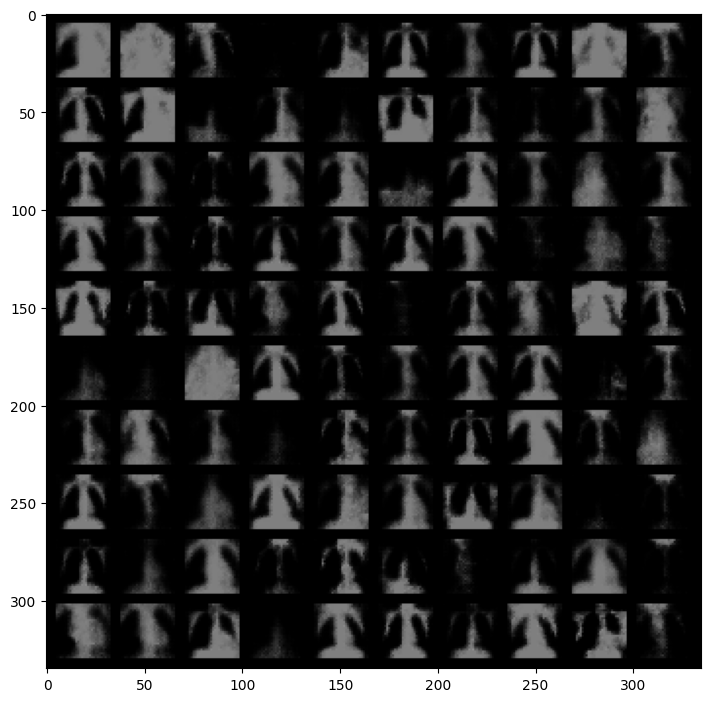

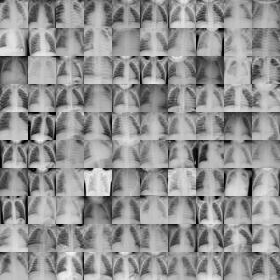

In [7]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader)._next_data()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

train_dataset.montage(length=10)

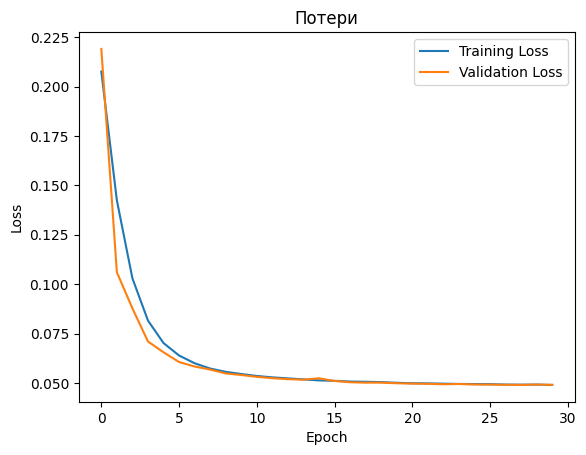

In [9]:
plt.plot(history_da['train_loss'], label='Training Loss')
plt.plot(history_da['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Потери')
plt.legend()
plt.show()

**По графикам потерь и метрике сделайте вывод была ли модель обучена, недообучена или переобучена.**

Ваш ответ: Модель была хорошо обучена, потери малы

**Если модель недообучена или переобучена, то что могло послужить причинами этого?**

Ваш ответ: -

## Контрольные вопросы

**В чем особенность архитектуры автокодировщиков?**

Ваш ответ: Автокодировщики - это нейронные сети, которые обучаются реконструировать входные данные, используя внутреннее кодирование. Они включают кодировщик, декодировщик, латентное пространство, используют потери для обучения и могут служить для снижения размерности и генерации данных.

**Какие метрики можно использовать для оценки качества изображений?**

Ваш ответ: 
MSE (Mean Squared Error): Среднеквадратичное отклонение.
MAE (Mean Absolute Error): Среднее абсолютное отклонение.
SSIM (Structural Similarity Index): Сходство в структуре изображений.
PSNR (Peak Signal-to-Noise Ratio): Отношение сигнал/шум.
Cosine Similarity: Косинусное сходство между векторами пикселей.
Гистограммные метрики: Анализ распределения цветов.
SSIM Map, MSE Map: Карты, показывающие, где возникают искажения.
